In [2]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math

import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

## K-means

In [3]:
ori_data = pd.read_csv('../Model_memory/playing_memory_880.csv')
ori_data

,episode,cart_position,cart_velocity,pole_angle,pole_angular_velocity,action,reward,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity,q_values
0,0,0.013870,0.026208,0.027376,0.033123,1,1.0,0.014394,0.220927,0.028038,-0.250798,"[17.424397, 18.431095]"
1,0,0.014394,0.220927,0.028038,-0.250798,1,1.0,0.018813,0.415638,0.023022,-0.534507,"[17.785023, 18.40013]"
2,0,0.018813,0.415638,0.023022,-0.534507,0,1.0,0.027126,0.220200,0.012332,-0.234660,"[18.670609, 18.5435]"
3,0,0.027126,0.220200,0.012332,-0.234660,1,1.0,0.031530,0.415143,0.007639,-0.523427,"[17.776121, 18.367172]"
4,0,0.031530,0.415143,0.007639,-0.523427,0,1.0,0.039833,0.219915,-0.002830,-0.228347,"[18.685854, 18.484688]"
...,...,...,...,...,...,...,...,...,...,...,...,...
281026,879,-2.213496,-2.209000,-0.093698,1.570399,1,1.0,-2.257676,-2.012893,-0.062290,1.250021,"[15.553661, 16.088898]"
281027,879,-2.257676,-2.012893,-0.062290,1.250021,0,1.0,-2.297934,-2.207164,-0.037290,1.522561,"[15.931983, 15.726796]"
281028,879,-2.297934,-2.207164,-0.037290,1.522561,1,1.0,-2.342077,-2.011611,-0.006839,1.218476,"[15.423721, 16.090506]"
281029,879,-2.342077,-2.011611,-0.006839,1.218476,0,1.0,-2.382310,-2.206644,0.017531,1.509008,"[15.83497, 15.593561]"


In [6]:
zero_rew = ori_data[ori_data['reward'] == 0]
zero_rew.shape

(880, 12)

In [7]:
one_rew = ori_data[ori_data['reward'] == 1].sample(880*10)
ori_data = pd.concat([zero_rew, one_rew])
ori_data.shape

(9680, 12)

In [8]:
data = ori_data[['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']]
data

,cart_position,cart_velocity,pole_angle,pole_angular_velocity
336,-2.358048,-2.226607,-0.024178,1.591586
665,-2.397833,-0.353248,-0.101106,-0.562308
970,-2.387133,-1.531806,0.145847,0.836995
1294,-2.389560,-0.525317,-0.088760,-0.274361
1603,-2.390681,-0.669805,-0.191036,-0.427039
...,...,...,...,...
236527,-0.856743,-0.004931,0.033126,-0.522051
149754,-1.411596,-0.304552,-0.090171,-0.482502
32158,-0.365196,-0.136575,-0.024993,-0.027638
33605,-1.505897,-1.480123,-0.060113,1.153274


/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


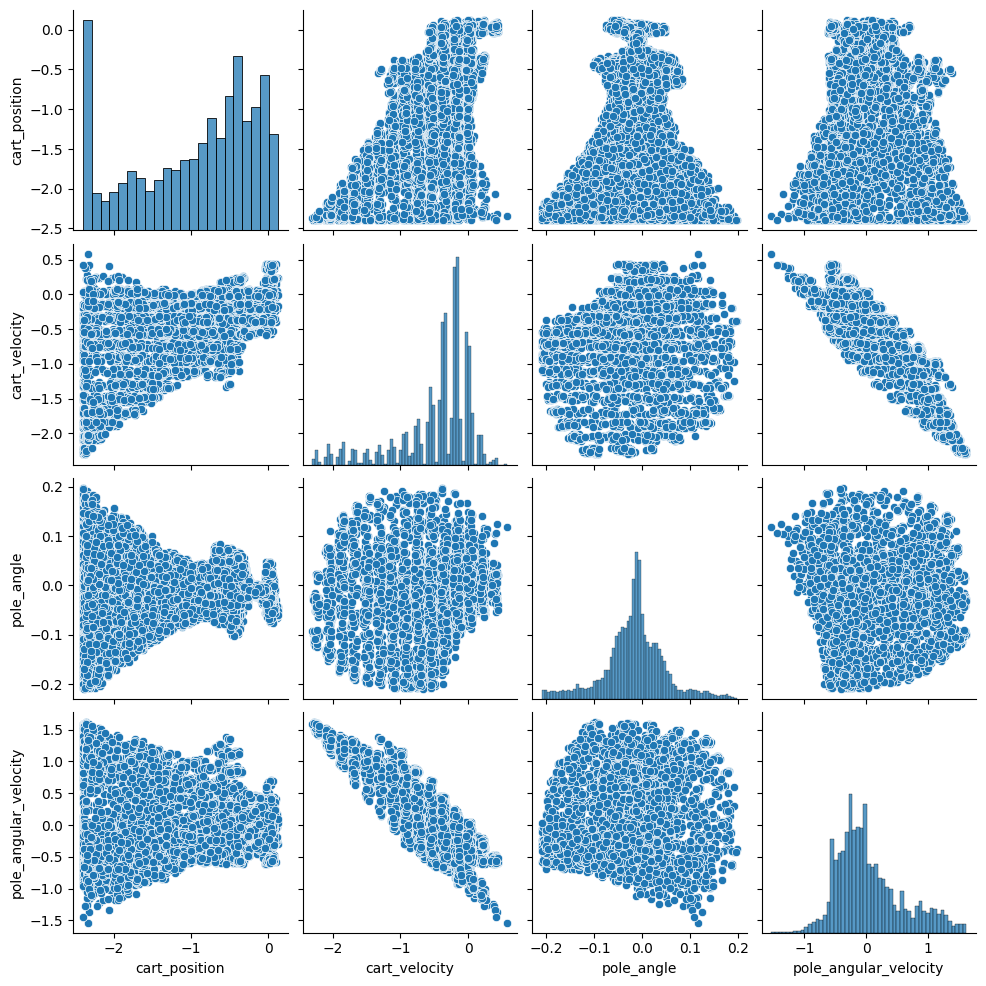

In [9]:
sns.pairplot(data)

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

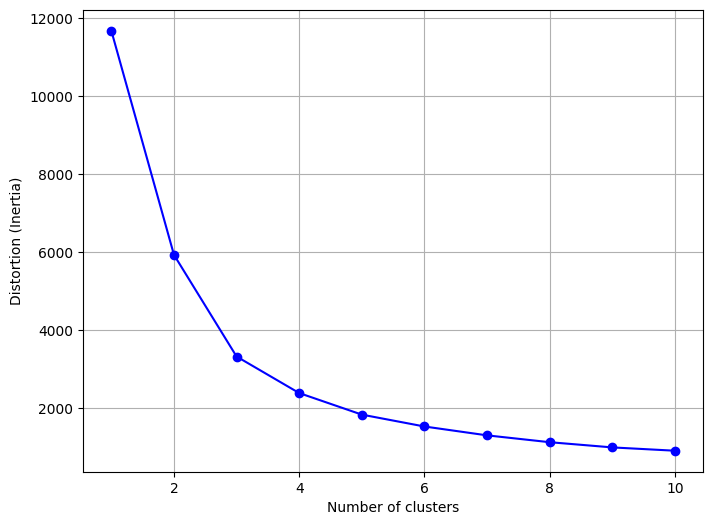

In [12]:
def elbow_method(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='-', color='b')
    #plt.title('Elbow Method for'+f' {var}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.grid(True)
    plt.show()

    # Return the number of clusters and their corresponding distortions
    return list(range(1, max_clusters + 1)), distortions


clusters, distortions = elbow_method(data = data)

In [15]:
def kmeans_clustering(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels

bin_df = data.copy()
optimal_num_clusters = 6

cluster_labels = kmeans_clustering(data, optimal_num_clusters)
bin_df['bin'] = cluster_labels

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,bin
336,-2.358048,-2.226607,-0.024178,1.591586,1
665,-2.397833,-0.353248,-0.101106,-0.562308,5
970,-2.387133,-1.531806,0.145847,0.836995,1
1294,-2.389560,-0.525317,-0.088760,-0.274361,5
1603,-2.390681,-0.669805,-0.191036,-0.427039,5
...,...,...,...,...,...
236527,-0.856743,-0.004931,0.033126,-0.522051,2
149754,-1.411596,-0.304552,-0.090171,-0.482502,2
32158,-0.365196,-0.136575,-0.024993,-0.027638,0
33605,-1.505897,-1.480123,-0.060113,1.153274,1


## Bin Threshold

In [17]:
thre_dic = {}
col = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']
for c in col:
    var_name = 'bin'
    ls = []
    for i in range(optimal_num_clusters):   
        mini = min(list(bin_df[bin_df[var_name] == i][c]))
        ls.append(mini)
    ls = sorted(ls)
    threshold = {}
    for i in range(optimal_num_clusters):
        if i == 0:
            threshold[i] = (-math.inf, ls[i+1])
        elif i < optimal_num_clusters-1:
            threshold[i] = (ls[i], ls[i+1])
        else:
            threshold[i] = (ls[i], math.inf)
    thre_dic[c] = threshold
thre_dic

{'cart_position': {0: (-inf, -2.3999386),
  1: (-2.3999386, -1.9460012),
  2: (-1.9460012, -1.6043862),
  3: (-1.6043862, -0.8419018),
  4: (-0.8419018, -0.7204568),
  5: (-0.7204568, inf)},
 'cart_velocity': {0: (-inf, -1.4636338),
  1: (-1.4636338, -1.1430725),
  2: (-1.1430725, -0.7526472),
  3: (-0.7526472, -0.7046855),
  4: (-0.7046855, -0.22839466),
  5: (-0.22839466, inf)},
 'pole_angle': {0: (-inf, -0.20146218),
  1: (-0.20146218, -0.15661636),
  2: (-0.15661636, -0.11674419),
  3: (-0.11674419, -0.10212591),
  4: (-0.10212591, -0.09485163),
  5: (-0.09485163, inf)},
 'pole_angular_velocity': {0: (-inf, -0.8471889),
  1: (-0.8471889, -0.6143664),
  2: (-0.6143664, -0.18185113),
  3: (-0.18185113, 0.13288449),
  4: (0.13288449, 0.15042588),
  5: (0.15042588, inf)}}

In [18]:
for c in col:
    var_thre = thre_dic[c]
    ls = []
    for d in list(bin_df[c]):
        for i in range(optimal_num_clusters):
            var_clus_thre = var_thre[i]
            if d <= var_clus_thre[1] and d > var_clus_thre[0]:
                ls.append(i)
    bin_df[c] = ls
bin_df = bin_df[col]
bin_df 

,cart_position,cart_velocity,pole_angle,pole_angular_velocity
336,1,0,5,5
665,1,4,4,2
970,1,0,5,5
1294,1,4,5,2
1603,1,4,1,2
...,...,...,...,...
236527,3,5,5,2
149754,3,4,5,2
32158,5,5,5,3
33605,3,0,5,5


In [19]:
new_col = ['new_cart_position', 'new_cart_velocity', 'new_pole_angle', 'new_pole_angular_velocity']
next_data = ori_data[new_col]
next_data

,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
336,-2.402580,-2.031207,0.007654,1.291463
665,-2.404898,-0.546817,-0.112352,-0.303112
970,-2.417769,-1.338945,0.162587,0.593502
1294,-2.400066,-0.329048,-0.094248,-0.593666
1603,-2.404077,-0.861781,-0.199577,-0.200137
...,...,...,...,...
236527,-0.856842,-0.200503,0.022685,-0.219117
149754,-1.417687,-0.498293,-0.099821,-0.219545
32158,-0.367928,0.058896,-0.025546,-0.328101
33605,-1.535500,-1.284270,-0.037048,0.842363


In [20]:
next_bin = next_data.copy()
for c in col:
    var_new = 'new_'+ c
    var_thre = thre_dic[c]
    ls = []
    for d in list(next_data[var_new]):
        for i in range(optimal_num_clusters):
            var_clus_thre = var_thre[i]
            if d <= var_clus_thre[1] and d > var_clus_thre[0]:
                ls.append(i)
    next_bin[var_new] = ls
next_bin 

,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
336,0,0,5,5
665,0,4,3,2
970,0,1,5,5
1294,0,4,5,2
1603,0,2,1,2
...,...,...,...,...
236527,3,5,5,2
149754,3,4,4,2
32158,5,5,5,2
33605,3,1,5,5


In [21]:
bin_df = pd.concat([bin_df, next_bin], axis = 1)
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
336,1,0,5,5,0,0,5,5
665,1,4,4,2,0,4,3,2
970,1,0,5,5,0,1,5,5
1294,1,4,5,2,0,4,5,2
1603,1,4,1,2,0,2,1,2
...,...,...,...,...,...,...,...,...
236527,3,5,5,2,3,5,5,2
149754,3,4,5,2,3,4,4,2
32158,5,5,5,3,5,5,5,2
33605,3,0,5,5,3,1,5,5


In [22]:
rew_act_df = ori_data[['reward', 'action']]
bin_df = pd.concat([bin_df, rew_act_df], axis=1)
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity,reward,action
336,1,0,5,5,0,0,5,5,0.0,1
665,1,4,4,2,0,4,3,2,0.0,0
970,1,0,5,5,0,1,5,5,0.0,1
1294,1,4,5,2,0,4,5,2,0.0,1
1603,1,4,1,2,0,2,1,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...
236527,3,5,5,2,3,5,5,2,1.0,0
149754,3,4,5,2,3,4,4,2,1.0,0
32158,5,5,5,3,5,5,5,2,1.0,1
33605,3,0,5,5,3,1,5,5,1.0,1


In [23]:
bin_df.to_csv('sample_data.csv', index=False) 

## Dagma

### Sample Data

In [24]:
df = pd.read_csv("sample_data.csv")
X = df.values
X

array([[1., 0., 5., ..., 5., 0., 1.],
       [1., 4., 4., ..., 2., 0., 0.],
       [1., 0., 5., ..., 5., 0., 1.],
       ...,
       [5., 5., 5., ..., 2., 1., 1.],
       [3., 0., 5., ..., 5., 1., 1.],
       [5., 4., 5., ..., 5., 1., 1.]])

In [25]:
node_names_dict = {index: column_name for index, column_name in enumerate(df.columns)}
node_names_dict

{0: 'cart_position',
 1: 'cart_velocity',
 2: 'pole_angle',
 3: 'pole_angular_velocity',
 4: 'new_cart_position',
 5: 'new_cart_velocity',
 6: 'new_pole_angle',
 7: 'new_pole_angular_velocity',
 8: 'reward',
 9: 'action'}

In [26]:
eq_model = DagmaMLP(dims=[10, 10, 1], bias=True, dtype=torch.double) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(X, lambda1=0.02, lambda2=0.005) 
W_est

100%|██████████| 230000/230000.0 [1:02:57<00:00, 60.89it/s]  


array([[0.        , 0.        , 0.80449291, 0.        , 0.36599918,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.34848068, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.09787204, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.35803403, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.01084855, 0.        ],
       [0.31324167, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

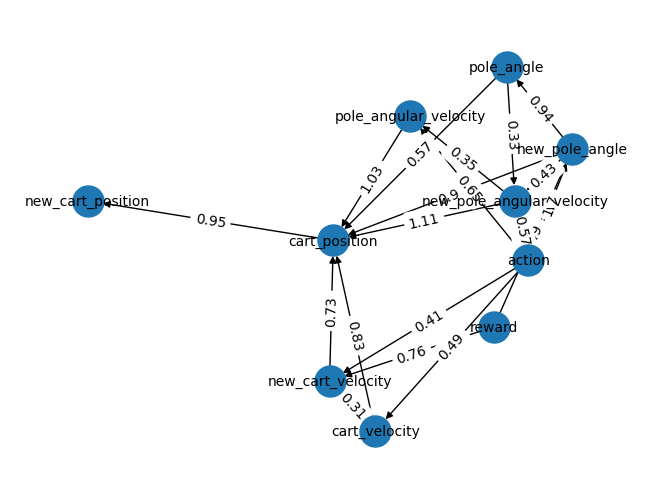

In [24]:
W_est = pd.DataFrame(W_est)
W_est = W_est.round(2)
# Create a directed graph (DiGraph)
G = nx.DiGraph()

# Add weighted edges based on the adjacency matrix
for row in range(W_est.shape[0]):
    for col in range(W_est.shape[1]):
        weight = W_est.iloc[row, col]
        if weight > 0:
            G.add_edge(row, col, weight=weight)

# Draw the graph
H = nx.relabel_nodes(G, node_names_dict)
pos = nx.spring_layout(H)  # Layout for visualization
edge_labels = {(u, v): d['weight'] for u, v, d in H.edges(data=True)}

# Draw the graph with custom node labels
nx.draw(H, pos, node_size=500, font_size=10, with_labels=True)

# Draw edge labels
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)

plt.margins(0.1) 
plt.show()

In [25]:
W_est

,0,1,2,3,4,5,6,7,8,9
0,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.0,0.0
1,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2,0.57,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.0,0.0
3,1.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
5,0.73,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
6,0.94,0.00,0.94,0.00,0.00,0.00,0.00,0.43,0.0,0.0
7,1.11,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.0,0.0
8,0.00,0.00,0.00,0.00,0.00,0.76,0.49,0.00,0.0,0.0
9,0.00,0.49,0.00,0.65,0.00,0.41,1.70,0.57,0.0,0.0


In [26]:
W_est.to_csv('W_est.csv', index=False) 

## Bayesian Network

In [1]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# Initialize the BayesianModel
model = BayesianNetwork()
W_est = pd.read_csv('W_est.csv')
W_est = W_est.to_numpy()
for node in node_names_dict.values():
    model.add_node(node)

for child in range(len(W_est)):
    for parent in range(len(W_est)):
        if W_est[parent][child] != 0:
            model.add_edge(node_names_dict[parent], node_names_dict[child])

model.edges()

OutEdgeView([('cart_position', 'new_cart_position'), ('cart_velocity', 'cart_position'), ('pole_angle', 'cart_position'), ('pole_angle', 'new_pole_angular_velocity'), ('pole_angular_velocity', 'cart_position'), ('new_cart_velocity', 'cart_position'), ('new_cart_velocity', 'cart_velocity'), ('new_pole_angle', 'cart_position'), ('new_pole_angle', 'pole_angle'), ('new_pole_angle', 'new_pole_angular_velocity'), ('new_pole_angular_velocity', 'cart_position'), ('new_pole_angular_velocity', 'pole_angular_velocity'), ('reward', 'new_cart_velocity'), ('reward', 'new_pole_angle'), ('action', 'cart_velocity'), ('action', 'pole_angular_velocity'), ('action', 'new_cart_velocity'), ('action', 'new_pole_angle'), ('action', 'new_pole_angular_velocity')])

In [27]:
model.fit(df, estimator=MaximumLikelihoodEstimator)

In [31]:
cart_position_cpd = model.get_cpds('new_cart_position')
print(cart_position_cpd)

+----------------------+------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+
| cart_position        | cart_position(0) | cart_position(1)     | cart_position(2)     | cart_position(3)      | cart_position(4)     | cart_position(5)     |
+----------------------+------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+
| new_cart_position(0) | 1.0              | 0.024489795918367346 | 0.0                  | 0.0                   | 0.0                  | 0.0                  |
+----------------------+------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+
| new_cart_position(1) | 0.0              | 0.9755102040816327   | 0.016587677725118485 | 0.0                   | 0.0                  | 0.0                  |
+----------------------+----------------

## BN Prediction

In [32]:
# Initialize the inference object
inference = VariableElimination(model)

# Set evidence
evidence = {'cart_velocity': 0}

# Perform inference to predict the distribution of node given the evidence
predicted_distribution = inference.query(variables=['new_cart_velocity'], evidence=evidence)
print(predicted_distribution)

+----------------------+--------------------------+
| new_cart_velocity    |   phi(new_cart_velocity) |
+======================+==========================+
| new_cart_velocity(0) |                   0.7901 |
+----------------------+--------------------------+
| new_cart_velocity(1) |                   0.2099 |
+----------------------+--------------------------+
| new_cart_velocity(2) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(3) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(4) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(5) |                   0.0000 |
+----------------------+--------------------------+
